# Playsense-id  model training

## 1.Basic analysis 

### 1.1  raw data 

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the data folder and file path
data_folder = "../data/"
data_file = "controller_data_user1_20250307_112616.csv"
file_path = os.path.join(data_folder, data_file)

# Check if the file exists before reading
if os.path.exists(file_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Display the first few rows of the DataFrame
    print("First 5 rows of the dataset:")
    display(df.head())
    
    # Count the values of the button_press column
    print("\nButton press counts:")
    display(df['button_press'].value_counts())
    
    # Display summary statistics
    print("\nSummary statistics:")
    display(df.describe())
    
    # Display information about the DataFrame
    print("\nDataFrame information:")
    df.info()
else:
    print(f"Error: File not found at {file_path}")
    print("Please check if the file exists or if the path is correct.")



First 5 rows of the dataset:


,timestamp,button_press,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z,user_id
0,2025-03-07T11:26:16.592564,none,0,0,0,0,0,0,user1
1,2025-03-07T11:26:16.597643,none,-491,8288,-1140,-55,-63,60,user1
2,2025-03-07T11:26:16.602667,none,-464,8259,-1143,-46,-63,64,user1
3,2025-03-07T11:26:16.606753,none,-449,8260,-1103,-36,-61,69,user1
4,2025-03-07T11:26:16.611815,none,-459,8284,-1092,-27,-60,71,user1



Button press counts:


button_press
none      5605
up         139
left        78
right       62
down        59
square      52
cross       32
circle      24
Name: count, dtype: int64


Summary statistics:


,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z
count,6051.000000,6051.000000,6051.000000,6051.000000,6051.000000,6051.000000
mean,-236.425549,7955.655098,-1503.924475,27.447695,-5.453314,36.862502
std,1066.765135,359.150505,1111.600017,401.740601,325.274700,395.302357
min,-2716.000000,0.000000,-4226.000000,-1731.000000,-2019.000000,-2308.000000
25%,-776.000000,7897.000000,-2084.500000,-25.000000,-14.000000,-17.000000
50%,-590.000000,7994.000000,-1911.000000,2.000000,5.000000,9.000000
75%,-179.000000,8147.000000,-986.000000,35.000000,30.000000,45.000000
max,3919.000000,9395.000000,3920.000000,2089.000000,1272.000000,2163.000000



DataFrame information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6051 entries, 0 to 6050
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     6051 non-null   object
 1   button_press  6051 non-null   object
 2   gyro_pitch    6051 non-null   int64 
 3   gyro_yaw      6051 non-null   int64 
 4   gyro_roll     6051 non-null   int64 
 5   acc_x         6051 non-null   int64 
 6   acc_y         6051 non-null   int64 
 7   acc_z         6051 non-null   int64 
 8   user_id       6051 non-null   object
dtypes: int64(6), object(3)
memory usage: 425.6+ KB


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from matplotlib.ticker import MaxNLocator


# ========= functions for the anlaysis the raw df =====================
def preprocess_data(df):
    """Preprocess the input DataFrame."""
    if df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    df_analysis = df.copy()
    return df_analysis

def extract_button_events(df_analysis):
    """Extract relevant button events and transitions."""
    button_events = df_analysis[~df_analysis['button_press'].str.contains('EVENT:', na=False)].copy()
    button_events['prev_button'] = button_events['button_press'].shift(1)
    button_events['is_transition'] = button_events['button_press'] != button_events['prev_button']
    button_events['press_start'] = (button_events['prev_button'] == 'none') & (button_events['button_press'] != 'none')
    button_events['press_end'] = (button_events['prev_button'] != 'none') & (button_events['button_press'] == 'none')
    return button_events

def detect_buttons(button_events):
    """Detect all unique buttons in the dataset."""
    all_buttons = set()
    for buttons in button_events['button_press'].unique():
        if isinstance(buttons, str) and buttons != 'none' and not buttons.startswith('EVENT:'):
            all_buttons.update(buttons.split(','))
    return all_buttons

def compute_button_statistics(button_events, all_buttons):
    """Compute statistics for each button."""
    press_starts = button_events[button_events['press_start']].copy()
    button_stats = {}
    for button in all_buttons:
        count = sum(press_starts['button_press'].str.contains(button, na=False))
        button_presses = button_events[button_events['button_press'].str.contains(button, na=False)].copy()
        if not button_presses.empty:
            button_presses.loc[:, 'group'] = button_presses['is_transition'].cumsum()
            grouped = button_presses.groupby('group')
            avg_sequence = grouped.size().mean()
            last_press = button_presses['timestamp'].max()
            sequences = [(group['timestamp'].max() - group['timestamp'].min()).total_seconds() * 1000 
                         for _, group in grouped if len(group) > 1]
            avg_duration = np.mean(sequences) if sequences else np.nan
            button_stats[button] = {
                'count': count,
                'avg_sequence_length': avg_sequence,
                'avg_duration_ms': avg_duration,
                'last_press': last_press
            }
    return pd.DataFrame.from_dict(button_stats, orient='index').reset_index().rename(columns={'index': 'button'}).sort_values('count', ascending=False)

def plot_button_statistics(stats_df, button_events, all_buttons):
    """Generate visualizations of button statistics."""
    plt.figure(figsize=(14, 10))
    
    plt.subplot(2, 2, 1)
    sns.barplot(x='button', y='count', data=stats_df)
    plt.title('Button Press Count')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.subplot(2, 2, 2)
    sns.barplot(x='button', y='avg_sequence_length', data=stats_df)
    plt.title('Average Sequence Length')
    plt.xticks(rotation=45)
    plt.ylabel('Readings per Press')
    
    plt.subplot(2, 2, 3)
    sns.barplot(x='button', y='avg_duration_ms', data=stats_df)
    plt.title('Average Duration (ms)')
    plt.xticks(rotation=45)
    plt.ylabel('Duration (ms)')
    
    plt.subplot(2, 2, 4)
    for button in all_buttons:
        button_df = button_events[button_events['button_press'].str.contains(button, na=False)]
        if not button_df.empty:
            plt.scatter(button_df['timestamp'], [button] * len(button_df), alpha=0.5, s=10, label=button)
    plt.title('Button Presses Over Time')
    plt.xlabel('Time')
    plt.yticks(list(all_buttons))
    plt.tight_layout()
    plt.show()

def analyze_button_sequences(button_events):
    """Analyze temporal patterns between button presses. For example A->B , B->C as pattern"""
    sequences = button_events[button_events['button_press'] != 'none'].copy()
    sequences.loc[:, 'time_diff'] = (sequences['timestamp'] - sequences['timestamp'].shift(1)).dt.total_seconds() * 1000
    sequences = sequences[~sequences['prev_button'].isna()]
    common_sequences = []
    for i in range(len(sequences) - 1):
        if sequences.iloc[i]['is_transition'] and sequences.iloc[i+1]['is_transition']:
            btn1, btn2 = sequences.iloc[i]['button_press'], sequences.iloc[i+1]['button_press']
            time_diff = sequences.iloc[i+1]['time_diff']
            if not pd.isna(time_diff) and btn1 != 'none' and btn2 != 'none':
                common_sequences.append((btn1, btn2, time_diff))
    if common_sequences:
        seq_df = pd.DataFrame(common_sequences, columns=['first_button', 'second_button', 'time_diff_ms'])
        sequence_counts = seq_df.groupby(['first_button', 'second_button']).size().reset_index(name='count').sort_values('count', ascending=False).head(10)
        timing_stats = seq_df.groupby(['first_button', 'second_button'])['time_diff_ms'].agg(['mean', 'std', 'min', 'max']).reset_index().sort_values('mean')
        return sequence_counts, timing_stats
    return None, None


def find_button_press_interval(df_analysis):
    """Find all the intervals between button presses and non-press periods."""
    # Ensure the data is sorted by timestamp
    df_analysis = df_analysis.sort_values(by='timestamp')
    
    # Create a column for time differences between consecutive rows
    df_analysis['time_diff'] = df_analysis['timestamp'].diff().dt.total_seconds() * 1000  # Convert to milliseconds
    
    # Separate the intervals into press and non-press periods
    press_intervals = df_analysis[df_analysis['button_press'] != 'none']['time_diff'].dropna()
    non_press_intervals = df_analysis[df_analysis['button_press'] == 'none']['time_diff'].dropna()

    # Calculate the length of non-press sequences between button presses
    non_press_lengths = []
    current_button = None
    non_press_count = 0
    
    for idx, row in df_analysis.iterrows():
        if row['button_press'] != 'none':
            if current_button is not None and non_press_count > 0:
                non_press_lengths.append(non_press_count)
            current_button = row['button_press']
            non_press_count = 0
        else:  # 'none' button press
            non_press_count += 1
    
    # Add the last sequence if it ends with 'none'
    if non_press_count > 0:
        non_press_lengths.append(non_press_count)
    
    # Plotting press intervals, non-press intervals, and non-press sequence lengths
    plt.figure(figsize=(14, 10))

    # Plot button press intervals
    plt.subplot(2, 2, 1)
    sns.histplot(press_intervals, kde=True, color='blue', bins=30)
    plt.title('Distribution of Button Press Intervals')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')
    
    # Plot non-press intervals
    plt.subplot(2, 2, 2)
    sns.histplot(non_press_intervals, kde=True, color='red', bins=30)
    plt.title('Distribution of Non-Press Intervals')
    plt.xlabel('Time Interval (ms)')
    plt.ylabel('Frequency')
    
    # Plot non-press sequence lengths
    plt.subplot(2, 2, 3)
    if non_press_lengths:
        ax = sns.histplot(non_press_lengths, kde=True, color='green', bins=30)
        plt.title('Distribution of Non-Press Sequence Lengths')
        plt.xlabel('Number of Consecutive Non-Press Records')
        plt.ylabel('Frequency')
        
        # Add the x-axis value labels only to bars with y value over 1
        for p in ax.patches:
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            if y > 0.5:  # Only label bars with height greater than 0.5
                ax.annotate(f'{int(x)}', (x, y), 
                            ha='center', va='bottom', fontsize=8)
    else:
        plt.text(0.5, 0.5, 'No non-press sequences found', 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()

    # Return only the two intervals needed by the calling function
    return press_intervals, non_press_intervals

# ==============functions for the raws ====================



# main function call to anlysis the df data to know the infor of the press button events 
def analyze_button_presses_with_intervals(df):
    """Function to execute button press analysis along with interval analysis."""
    df_analysis = preprocess_data(df)
    button_events = extract_button_events(df_analysis)
    all_buttons = detect_buttons(button_events)
    print(f"Detected buttons: {', '.join(sorted(all_buttons))}")
    
    # Compute statistics and visualize button press events
    stats_df = compute_button_statistics(button_events, all_buttons)
    display(stats_df)
    plot_button_statistics(stats_df, button_events, all_buttons)
    
    # Analyze and visualize button press and non-press intervals
    press_intervals, non_press_intervals = find_button_press_interval(df_analysis)

    # Optional: Print interval statistics (mean, std, etc.)
    print(f"\nPress Intervals: Mean = {press_intervals.mean():.2f} ms, Std = {press_intervals.std():.2f} ms")
    print(f"Non-Press Intervals: Mean = {non_press_intervals.mean():.2f} ms, Std = {non_press_intervals.std():.2f} ms")
    
    # Analyze button sequences
    sequence_counts, timing_stats = analyze_button_sequences(button_events)
    if sequence_counts is not None:
        print("\nTop 10 Most Common Button Sequences:")
        display(sequence_counts)
        print("\nTiming Between Button Sequences (ms):")
        display(timing_stats)
    else:
        print("No button sequences detected in the data.")
    
    if not stats_df.empty:
        most_pressed = stats_df.iloc[0]
        print(f"\nMost pressed button: {most_pressed['button']} ({most_pressed['count']} times)")
        valid_durations = stats_df.dropna(subset=['avg_duration_ms'])
        if not valid_durations.empty:
            longest_press = valid_durations.iloc[valid_durations['avg_duration_ms'].idxmax()]
            print(f"Button with longest average press: {longest_press['button']} ({longest_press['avg_duration_ms']:.2f} ms)")

Detected buttons: circle, cross, down, left, right, square, up


,button,count,avg_sequence_length,avg_duration_ms,last_press
1,up,4,34.75,168.396,2025-03-07 11:26:43.644303
0,right,2,31.00,149.826,2025-03-07 11:26:43.127398
2,left,2,39.00,188.871,2025-03-07 11:26:41.847694
3,down,2,29.50,141.712,2025-03-07 11:26:42.421261
6,square,2,26.00,124.262,2025-03-07 11:26:39.552093
4,cross,1,32.00,155.041,2025-03-07 11:26:39.999734
5,circle,1,24.00,114.504,2025-03-07 11:26:40.497528


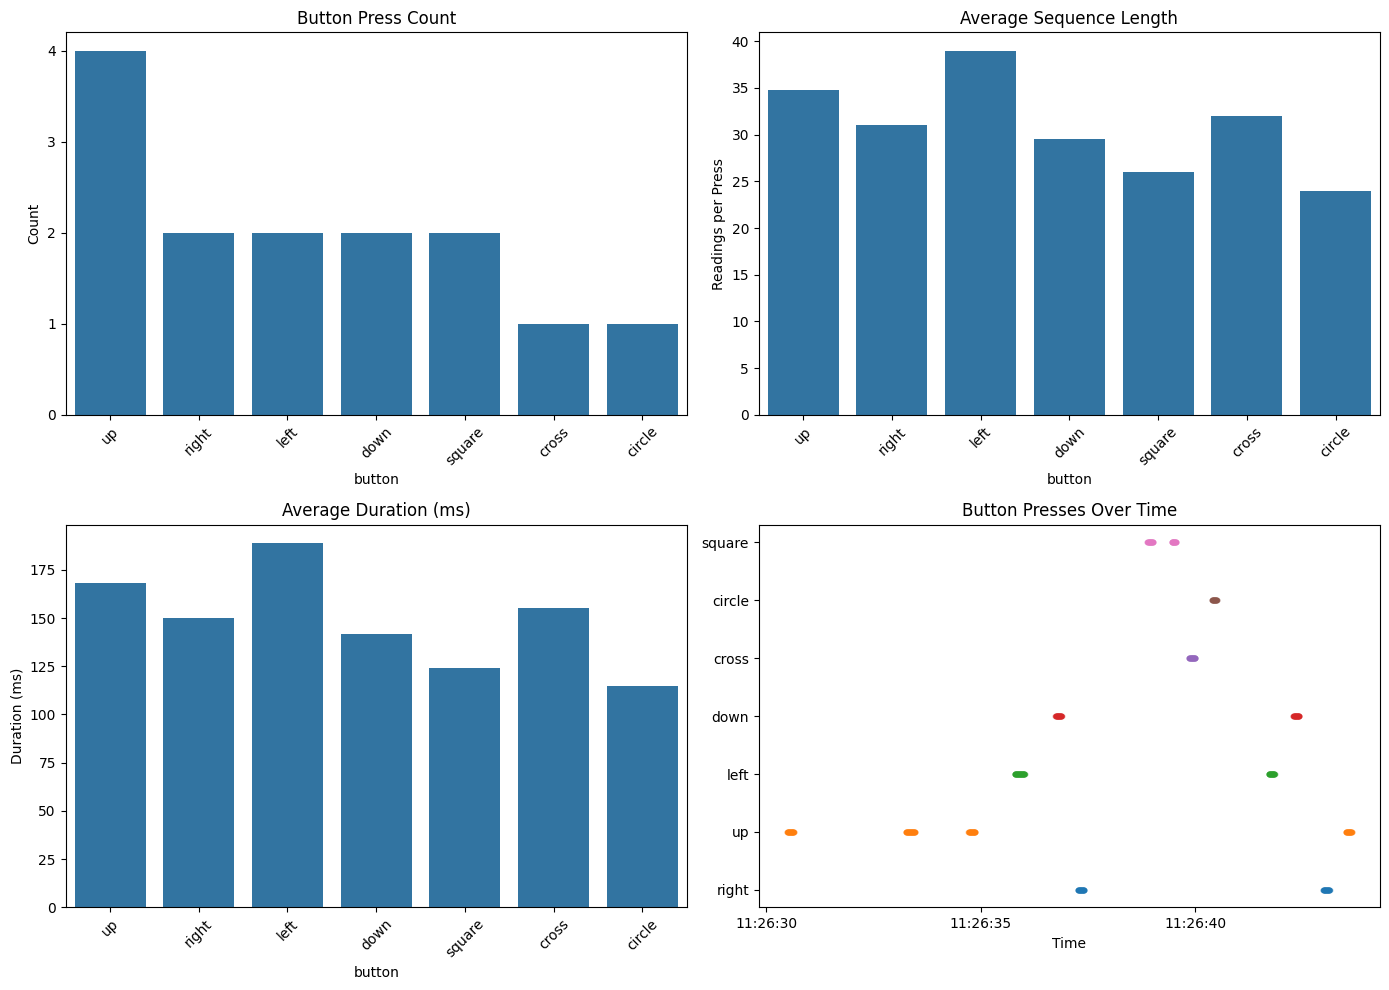

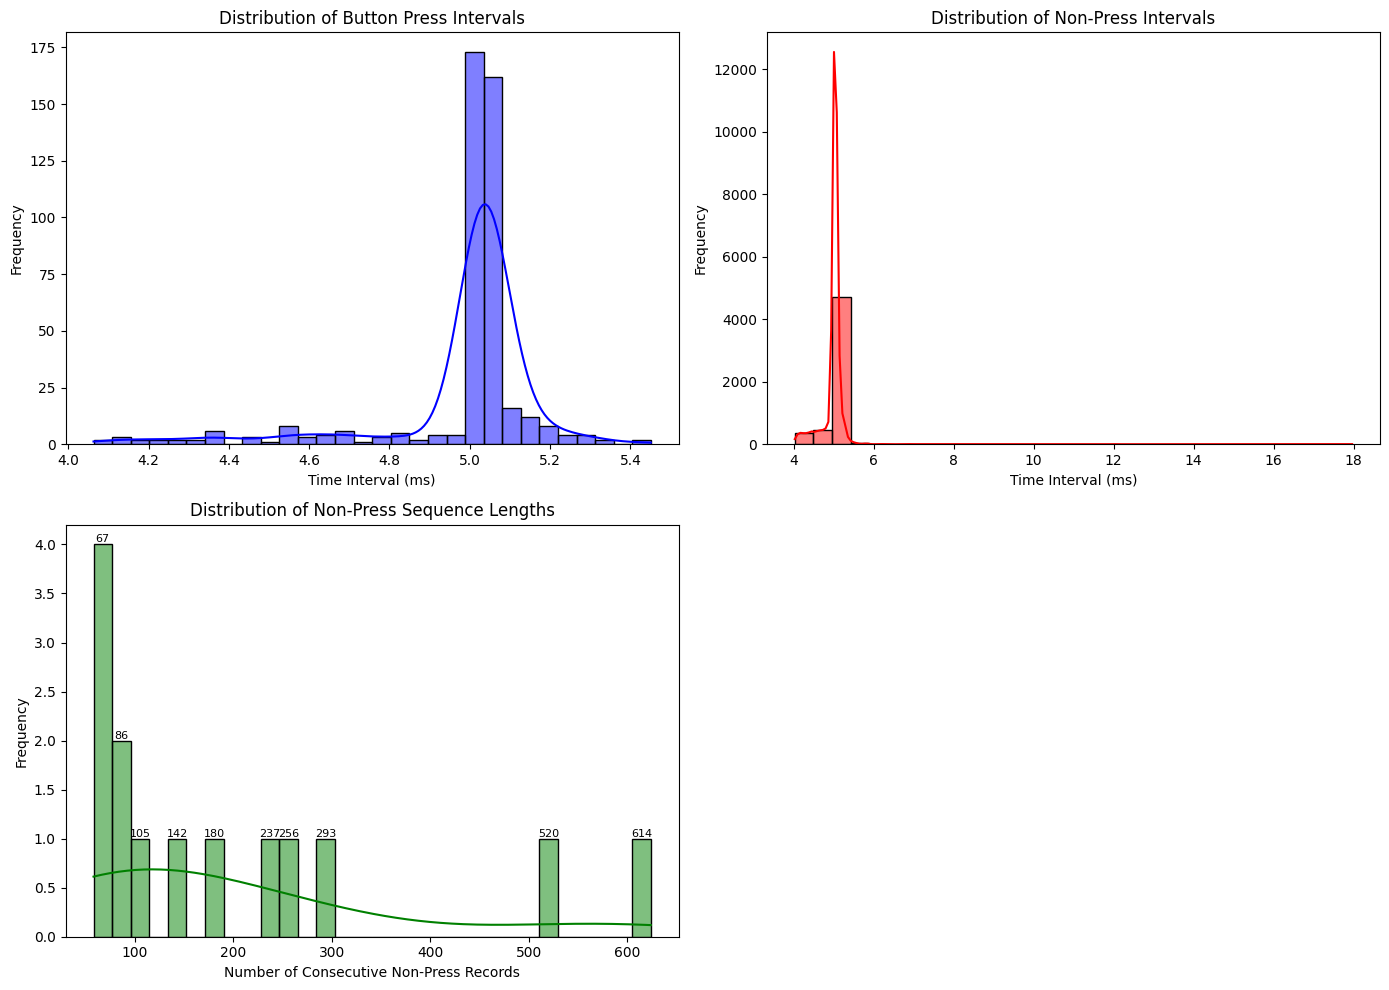


Press Intervals: Mean = 4.99 ms, Std = 0.20 ms
Non-Press Intervals: Mean = 4.99 ms, Std = 0.31 ms
No button sequences detected in the data.

Most pressed button: up (4 times)
Button with longest average press: left (188.87 ms)


In [31]:
analyze_button_presses_with_intervals(df=df)

the interval between the button press and non-press will define the extra data length

### 1.2 Extra method 

- 200 records: 100 before press, 100 after press
- reog to new dataframe

In [32]:
def extract_press_events(csv_file, output_file):
    """
    Extract button press events from a CSV file and save them as a new dataset.
    Each event contains 200 records: 100 before the first button press and 100 after.
    
    Parameters:
    csv_file (str): Path to the input CSV file.
    output_file (str): Path to save the output CSV file.
    """
    # Load data
    df = pd.read_csv(csv_file)
    
    # Ensure timestamp is datetime if present
    if 'timestamp' in df.columns and df['timestamp'].dtype == 'object':
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Identify indices where button press starts (first occurrence of a non-'none' value after 'none')
    press_indices = df.index[df['button_press'].shift(1, fill_value='none') == 'none']
    press_indices = press_indices[df.loc[press_indices, 'button_press'] != 'none']
    
    # Extract events (100 records before and 100 after each detected press)
    event_segments = []
    for idx in press_indices:
        start_idx = max(0, idx - 50)  # Ensure index does not go below 0
        end_idx = min(len(df), idx + 50)  # Ensure index does not exceed dataset length
        event_segments.append(df.iloc[start_idx:end_idx])
    
    # Concatenate all event segments into a new DataFrame
    extracted_data = pd.concat(event_segments).reset_index(drop=True)
    
    # Save extracted data to a new CSV file
    extracted_data.to_csv(output_file, index=False)
    print(f"Extracted data saved to {output_file}")


# 100 + 100 is too long for the quick change of the button pressing, cause the overlap in the data 

In [33]:
# Rename the output as xxx.csv to xxx_pro.csv
# 
import os 

file_name = os.path.basename(file_path)
file_base, file_ext = os.path.splitext(file_name)
file_out = os.path.join(os.path.dirname(file_path), f"{file_base}_pro{file_ext}")

extract_press_events(file_path,file_out)

Extracted data saved to ../data\controller_data_user1_20250307_112616_pro.csv


Processed data shape: (1400, 9)

First few rows of processed data:


,timestamp,button_press,gyro_pitch,gyro_yaw,gyro_roll,acc_x,acc_y,acc_z,user_id
0,2025-03-07 11:26:30.229072,none,-1033,7907,-2113,36,-15,19,user1
1,2025-03-07 11:26:30.234104,none,-1055,7870,-2135,34,-15,22,user1
2,2025-03-07 11:26:30.239138,none,-1068,7897,-2141,24,-13,24,user1
3,2025-03-07 11:26:30.244168,none,-1102,7854,-2144,17,-10,26,user1
4,2025-03-07 11:26:30.249582,none,-1032,7844,-2143,-4,-2,34,user1



Button press events in processed data:


button_press
up        139
left       78
right      62
down       59
square     52
cross      32
circle     24
Name: count, dtype: int64

Detected buttons: circle, cross, down, left, right, square, up


,button,count,avg_sequence_length,avg_duration_ms,last_press
1,up,4,34.75,168.396,2025-03-07 11:26:43.644303
0,right,2,31.00,149.826,2025-03-07 11:26:43.127398
2,left,2,39.00,188.871,2025-03-07 11:26:41.847694
3,down,2,29.50,141.712,2025-03-07 11:26:42.421261
6,square,2,26.00,124.262,2025-03-07 11:26:39.552093
4,cross,1,32.00,155.041,2025-03-07 11:26:39.999734
5,circle,1,24.00,114.504,2025-03-07 11:26:40.497528


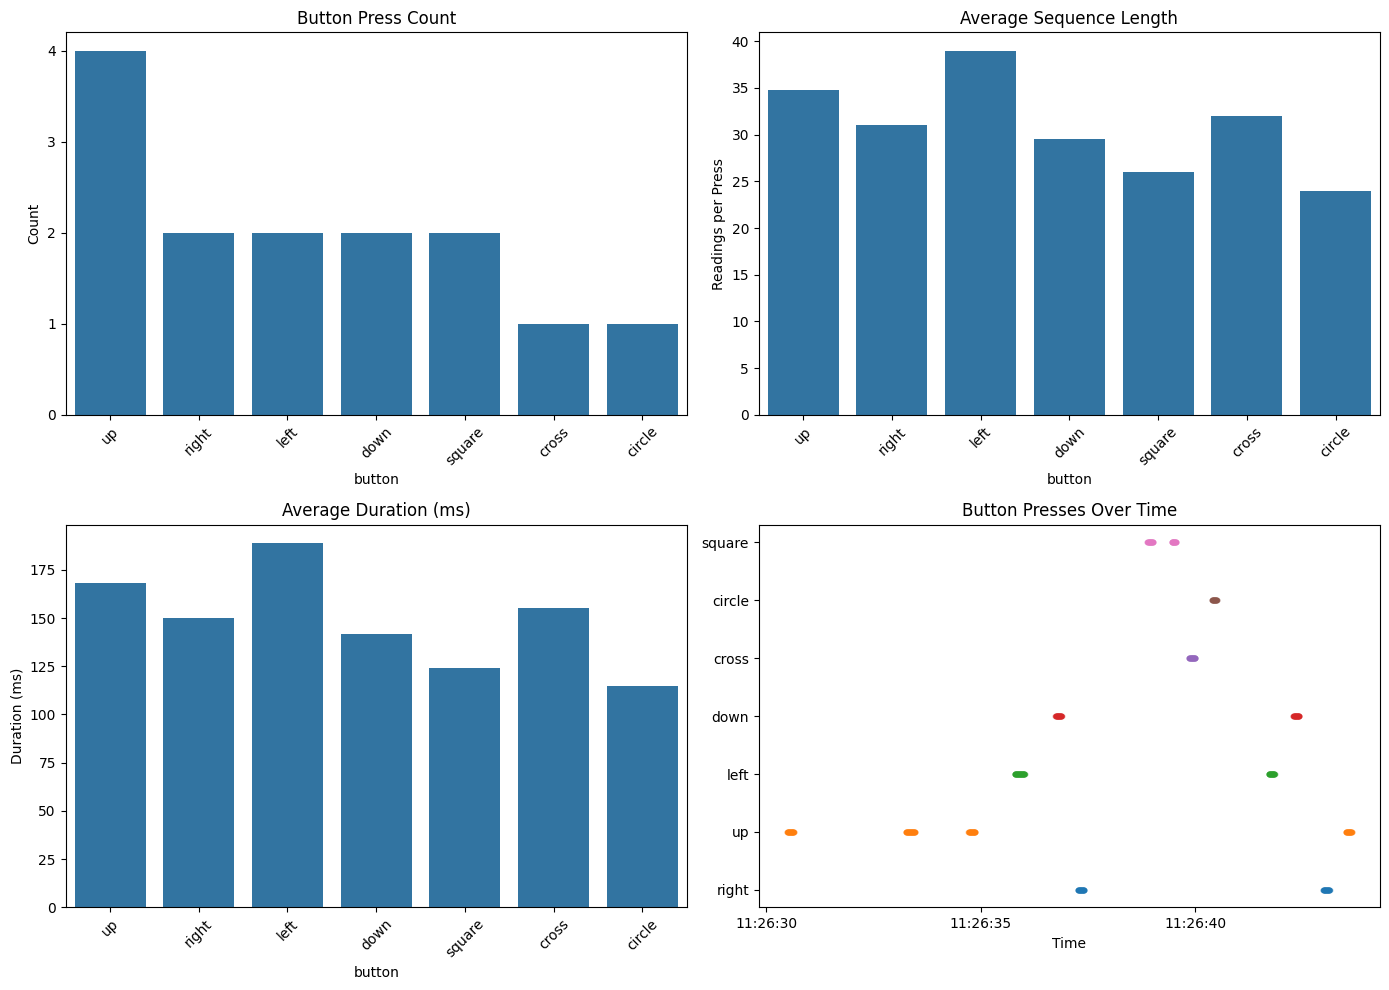

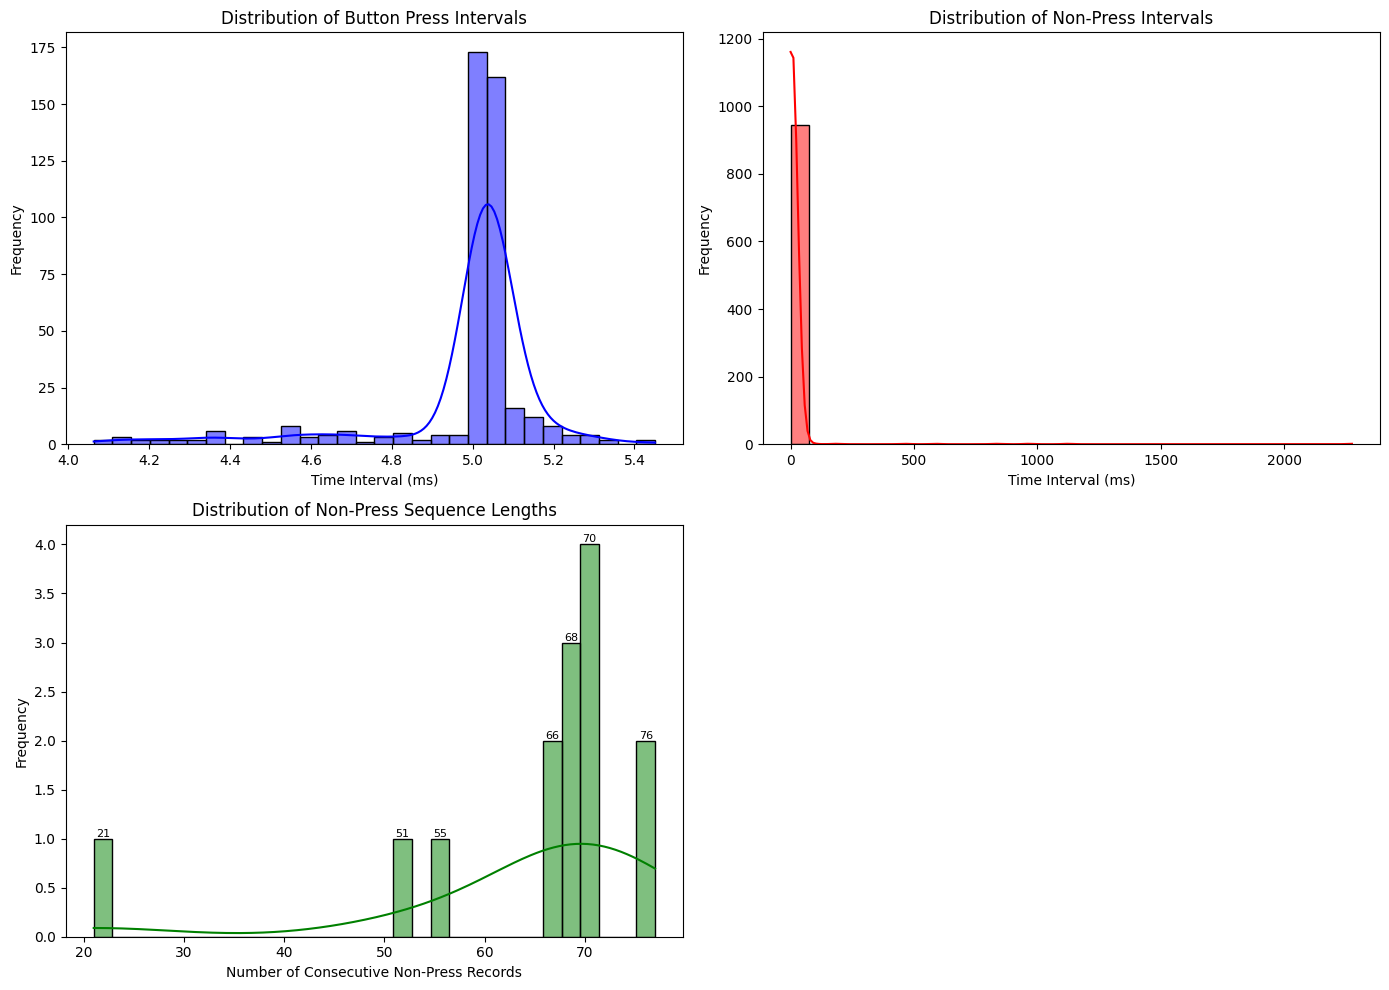


Press Intervals: Mean = 4.99 ms, Std = 0.20 ms
Non-Press Intervals: Mean = 11.85 ms, Std = 94.70 ms
No button sequences detected in the data.

Most pressed button: up (4 times)
Button with longest average press: left (188.87 ms)


In [34]:
# compare the extra or post-extra

# read the file_out into the df_post
df_post = pd.read_csv(file_out)

# Display basic information about the processed data
print(f"Processed data shape: {df_post.shape}")
print("\nFirst few rows of processed data:")
display(df_post.head())

# Count button press events by type
button_counts = df_post[df_post['button_press'] != 'none']['button_press'].value_counts()
print("\nButton press events in processed data:")
display(button_counts)


analyze_button_presses_with_intervals(df=df_post)


## Baseline model 
- SVM

In [ ]:
# baseline model ,svm one lable model 
